## Data Import

Data import for 5 datasets from gob and concatenate into a DataFrame

In [87]:
# Imports
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt

# Files config
data_2021 = 'datasets\dat-ab-usos-2021.csv'
data_2022 = 'datasets\dat-ab-usos-2022.csv'
data_2023 = 'datasets\dat-ab-usos-2023.csv'
data_2024 = 'datasets\dat-ab-usos-2024.csv'
data_2025 = 'datasets\dat-ab-usos-2025.csv'


# Read CSV
try:
    df_2021 = pd.read_csv(data_2021)
except FileNotFoundError:
    print(f"Error: El archivo {data_2021} no se encontró.")
    df_2021 = pd.DataFrame()  # Empty DataFrame in case of Error

try:
    df_2022 = pd.read_csv(data_2022)
except FileNotFoundError:
    print(f"Error: El archivo {data_2022} no se encontró.")
    df_2022 = pd.DataFrame()  # Empty DataFrame in case of Error

try:
    df_2023 = pd.read_csv(data_2023)
except FileNotFoundError:
    print(f"Error: El archivo {data_2023} no se encontró.")
    df_2023 = pd.DataFrame()  # Empty DataFrame in case of Error

try:
    df_2024 = pd.read_csv(data_2024)
except FileNotFoundError:
    print(f"Error: El archivo {data_2024} no se encontró.")
    df_2024 = pd.DataFrame()  # Empty DataFrame in case of Error
    
try:
    df_2025 = pd.read_csv(data_2025)
except FileNotFoundError:
    print(f"Error: El archivo {data_2025} no se encontró.")
    df_2025 = pd.DataFrame()  # Empty DataFrame in case of Error


In [88]:
# If everything is okey, we concat() the DataFrames
dataframes_list = [df for df in [df_2021, df_2022, df_2023, df_2024, df_2025] if not df.empty]

if dataframes_list:
    df_concat = pd.concat(dataframes_list, ignore_index=True)
    print("Success.")
else:
    df_concat = pd.DataFrame() # Empty DataFrame

Success.


## Change DataType

Change the DataType for the column "DIA_TRANSPORTE" (Transport Day) to datetime.

In [91]:
# After df_concat.info() -> Almost 1.83M rows.

df_newDataType = df_concat

# DIA_TRANSPORTE to Date.
df_newDataType['DIA_TRANSPORTE'] = pd.to_datetime(
    df_newDataType['DIA_TRANSPORTE'], 
    errors='coerce'
)
df_newDataType['DIA_TRANSPORTE'].head(3) # Year-Month-Day

0   2021-01-01
1   2021-01-01
2   2021-01-01
Name: DIA_TRANSPORTE, dtype: datetime64[ns]

## NULL COUNT

Check for NULL Count in entries.

In [92]:
null_count = df_newDataType.isnull().sum()
total_row = len(df_newDataType)
percentage_null = (null_count / total_row) * 100
# print(percentage_null)

df_nulls = pd.DataFrame({
    'Null Count': null_count, 
    'Percentage of Null (%)': percentage_null.round(2)
})
df_nulls_relevant = df_nulls[df_nulls['Null Count'] > 0]
print(df_nulls_relevant)

              Null Count  Percentage of Null (%)
JURISDICCION       13141                    0.56
PROVINCIA          13178                    0.57
MUNICIPIO          13178                    0.57


## Negative Values

Check for Negative Values in Quantity in the dataframe.

In [93]:
if (df_newDataType['CANTIDAD'] < 0).any():
    qty_negatives = (df_newDataType['CANTIDAD'] < 0).sum()
    print(f"Column CANTIDAD has {qty_negatives} negative values")
    df_newDataType.loc[df_newDataType['CANTIDAD'] < 0, 'CANTIDAD'] = 0
else:
    print(f"No negative values for column CANTIDAD")

# It had 11 negative values -> assign to 0

Column CANTIDAD has 11 negative values


## Add a column: day of the week

Add a new column with the day of the week (Monday, Tuesdat, ...) for future exploration analysis.

In [94]:
df = df_newDataType

df['DIA_SEMANA'] = df['DIA_TRANSPORTE'].dt.day_name()
print(df[['DIA_TRANSPORTE', 'DIA_SEMANA', 'CANTIDAD']].head())
# print(df['DIA_SEMANA'].value_counts())

  DIA_TRANSPORTE DIA_SEMANA  CANTIDAD
0     2021-01-01     Friday      1466
1     2021-01-01     Friday       625
2     2021-01-01     Friday      1119
3     2021-01-01     Friday      2813
4     2021-01-01     Friday        99


## Unique Values in Categoric Data

Count for unique values and handle the data.

In [95]:
unique_counts = df.nunique().sort_values(ascending=False)
print(unique_counts)

CANTIDAD           88562
LINEA               1946
DIA_TRANSPORTE      1802
NOMBRE_EMPRESA       396
MUNICIPIO             99
PROVINCIA             23
DIA_SEMANA             7
TIPO_TRANSPORTE        5
JURISDICCION           4
AMBA                   2
DATO_PRELIMINAR        2
dtype: int64


Checking for errors in categoric data

In [96]:
categoric_columns = [
    'DATO_PRELIMINAR', 
    'AMBA', 
    'JURISDICCION', 
    'TIPO_TRANSPORTE', 
    'DIA_SEMANA', 
    'PROVINCIA',
    'MUNICIPIO'
]

for column in categoric_columns:
    print(f"\nUnique values for column: **{column}**")
    print(df[column].value_counts(dropna=False))
    print("-" * 50)


Unique values for column: **DATO_PRELIMINAR**
DATO_PRELIMINAR
NO    2271321
SI      59277
Name: count, dtype: int64
--------------------------------------------------

Unique values for column: **AMBA**
AMBA
NO    1597098
SI     733500
Name: count, dtype: int64
--------------------------------------------------

Unique values for column: **JURISDICCION**
JURISDICCION
PROVINCIAL    1103520
MUNICIPAL      922469
NACIONAL       282147
NaN             13141
C.A.B.A          9321
Name: count, dtype: int64
--------------------------------------------------

Unique values for column: **TIPO_TRANSPORTE**
TIPO_TRANSPORTE
COLECTIVO    2277861
TREN           31514
SUBTE          13141
LANCHAS         8073
CIRCULAR           9
Name: count, dtype: int64
--------------------------------------------------

Unique values for column: **DIA_SEMANA**
DIA_SEMANA
Wednesday    346391
Tuesday      345900
Thursday     345190
Friday       344880
Monday       342736
Saturday     315680
Sunday       289821
Name

### Correct NaN Values

* There are 13141 NaN values in JURISDICCION and 13141 NaN values in the SUBTE (Metro) Transportation
* Few errors in "AMBA". If PROVINCIA = C.A.B.A -> AMBA should be YES.


In [97]:
# There is 13141 NaN values in JURISDICCION and we prove that those
# are all in the SUBTE (METRO) transportation.
mask_subte = df['TIPO_TRANSPORTE'] == 'SUBTE'
df_subte = df[mask_subte]
print(df_subte['TIPO_TRANSPORTE'].value_counts(dropna=False))
print(df_subte['PROVINCIA'].value_counts(dropna=False))


TIPO_TRANSPORTE
SUBTE    13141
Name: count, dtype: int64
PROVINCIA
NaN    13141
Name: count, dtype: int64


In [98]:
# All entries with CABA as JURISDICCION use CABA as PROVINCIA and "SD" as MUNICIPIO.
# SUBTE (Metro) is only used in CABA.

# MASK
mask_subte = df['TIPO_TRANSPORTE'] == 'SUBTE'

# 1. JURISDICCION to NACIONAL
df.loc[mask_subte, 'JURISDICCION'] = 'NACIONAL'

# 2. PROVINCIA to CABA
df.loc[mask_subte, 'PROVINCIA'] = 'CABA'

# 3. MUNICIPIO to 'SD'
df.loc[mask_subte, 'MUNICIPIO'] = 'SD'

print(df[mask_subte].head(1)[['TIPO_TRANSPORTE', 'JURISDICCION', 'PROVINCIA', 'MUNICIPIO']])

    TIPO_TRANSPORTE JURISDICCION PROVINCIA MUNICIPIO
361           SUBTE     NACIONAL      CABA        SD


In [99]:
condition_error_amba = (df['PROVINCIA'] == 'CABA') & \
                       (df['AMBA'] == 'NO')

# Correct to AMBA = SI.
df.loc[condition_error_amba, 'AMBA'] = 'SI'

print(f"Rows corrected: (AMBA: NO -> AMBA: SI): {condition_error_amba.sum()}")

Rows corrected: (AMBA: NO -> AMBA: SI): 8


## OUTLIERS

Check for outliers in the quantity of travels per entry.
* Using describe() method for a quick analysis.
* Box Plot with Matplotlib.

In [1]:
df_outliers = df
df_outliers['CANTIDAD'].describe()


NameError: name 'df' is not defined

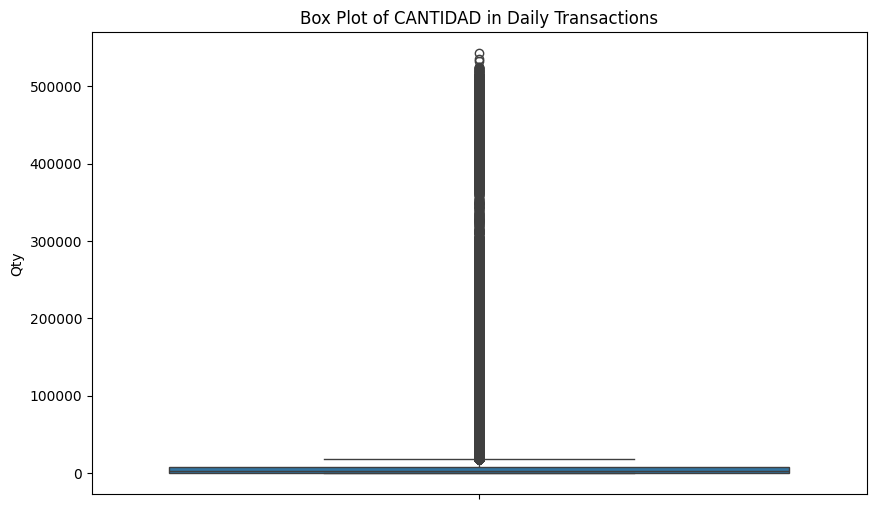


Q1 (25%): 549
Q3 (75%): 7,770
IQR: 7,221
Upper bound for Outliers: 18,602
Number of Outliers: 288,848


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(y=df_outliers['CANTIDAD'])

plt.title('Box Plot of CANTIDAD in Daily Transactions')
plt.ylabel('Qty')
plt.show()

Q1 = df_outliers['CANTIDAD'].quantile(0.25)
Q3 = df_outliers['CANTIDAD'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

print(f"\nQ1 (25%): {Q1:,.0f}")
print(f"Q3 (75%): {Q3:,.0f}")
print(f"IQR: {IQR:,.0f}")
print(f"Upper bound for Outliers: {upper_bound:,.0f}")

# Count outliers
outliers_count = df_outliers[df_outliers['CANTIDAD'] > upper_bound].shape[0]
print(f"Number of Outliers: {outliers_count:,}")

The analysis of the CANTIDAD (Quantity of daily uses) column reveals a heavily skewed distribution, which is typical for count data like transportation usage.

**Key Findings**
* High Positive Skewness: The Mean ($\text{8,177}$) is significantly higher than the Median ($\text{2,191}$). This indicates that the vast majority of daily usages are low, but the average is drastically pulled up by a smaller number of days/lines with extremely high transaction volumes.
* Extensive Outlier Count: The standard Interquartile Range (IQR) rule ($1.5 \times \text{IQR}$) identifies $\text{288,848}$ records (12.4% of the data) as outliers (i.e., $\text{CANTIDAD} > \text{18,602}$).

Conclusion on Outlier Treatment
In the context of public transportation data, these high values are not errors, but rather a representation of real-world high demand.
* Entries classified as "outliers" likely correspond to major bus routes or highly transited lines during peak weekdays
* Recommendation: We will not remove these records, as they contain critical information regarding high-demand events.
* Strategy for Modeling: For any future statistical modeling or predictive analysis, the CANTIDAD column should be handled by using the Median as a measure of central tendency or by applying a logarithmic transformation to mitigate the skewness and stabilize the variance.

In [ ]:
upper_bound = 18602 # From previous analysis.

# Outliers dataframe
df_with_outliers = df_outliers[df_outliers['CANTIDAD'] > upper_bound]

# Categorical Analysis of outliers
print("\nTop 5 TIPOS DE TRANSPORTE in Outliers:")
print(df_with_outliers['TIPO_TRANSPORTE'].value_counts(normalize=True).head())

print("\nTop 5 PROVINCIAS in Outliers:")
print(df_with_outliers['PROVINCIA'].value_counts(normalize=True).head())

# 4. Max outlier
max_register = df_with_outliers.sort_values(by='CANTIDAD', ascending=False).head(1)
print("\nMax register:")
print(max_register[['DIA_TRANSPORTE', 'LINEA', 'PROVINCIA', 'TIPO_TRANSPORTE', 'CANTIDAD']])


Top 5 TIPOS DE TRANSPORTE in Outliers:
TIPO_TRANSPORTE
COLECTIVO    0.920992
TREN         0.044091
SUBTE        0.034916
Name: proportion, dtype: float64

Top 5 PROVINCIAS in Outliers:
PROVINCIA
JN              0.499266
BUENOS AIRES    0.429100
CABA            0.034919
C.A.B.A         0.018995
SANTA FE        0.013237
Name: proportion, dtype: float64

Max register:
        DIA_TRANSPORTE      LINEA PROVINCIA TIPO_TRANSPORTE  CANTIDAD
1215121     2023-10-12  FFCC ROCA        JN            TREN    542616


The decision is: **KEEP ALL DATA.** 

The outliers are not measurement errors; they are real demand spikes in the system. 
Reason: Removing 288,848 records (12.4%) would mean erasing all information about operations on high-traffic days (peak hours and main lines), which is crucial for any planning, capacity, or transportation system performance analysis. 

*Analysis Strategy:* Instead of deleting, we should use the **median** for central tendency analysis and consider logarithmic transformation if the QUANTITY column is used in future predictive models.

## EXPORT Clean Data to new CSV


In [117]:
output_path = "datasets/sube_transactions_cleaned.csv"

df.to_csv(output_path, index=False, encoding='utf-8')

import os
tamano_mb = os.path.getsize(output_path) / (1024 * 1024)
print(f"Tamaño del archivo: {tamano_mb:.2f} MB")

Tamaño del archivo: 251.33 MB
